In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import seaborn as sb
import pandas as pd

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [2]:
modeldir = "/uscms_data/d3/ekoenig/6BAnalysis/CMSSW_10_2_18/src/sixB/analysis/sixBanalysis/models/2jet_classifier"
model = Model(modeldir)

In [3]:
input_tree = Tree(fc.sr.NN_NMSSM_MX_700_MY_400)

In [4]:
sixb_filter = CollectionFilter("jet",signalId_neq=-1)
all_sixb = EventFilter("all_sixb",nfound_presel=6)

In [5]:
training_preproc = all_sixb.filter(input_tree.subset(100000),filter=sixb_filter)
training = nn2j.process(training_preproc,model)

100%|██████████| 15/15 [00:08<00:00,  1.70it/s]


In [6]:
testing_preproc = all_sixb.filter(input_tree.subset(100000),filter=sixb_filter)
testing = nn2j.process(testing_preproc,model)

100%|██████████| 15/15 [00:08<00:00,  1.71it/s]


In [7]:
validation_preproc = input_tree.subset(50000)
validation = nn2j.process(validation_preproc,model)

100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


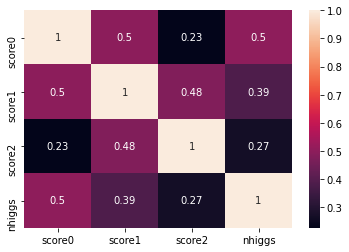

In [8]:
trainingdf = nn2j.to_pandas(training)
trainingcorr = trainingdf.corr()
ax = sb.heatmap(trainingcorr,annot=True)

In [179]:
def event_reshape(scores,truth):
    scores,truth = np.array(scores),np.array(truth)
    nevents = len(scores)//15
    return scores.reshape(nevents,15),truth.reshape(nevents,15)

def get_signal_bkgs(scores,truth):
    scores,truth = event_reshape(scores,truth)

    tru_scores = scores[truth]
    fak_scores = scores[~truth]
    fak_scores = fak_scores.reshape(len(fak_scores)//14,14)
    max_bkgs = np.max(fak_scores,axis=-1)

    return tru_scores,max_bkgs

In [169]:
fak

<Array [[0.181, 0.315, 0.322, ... 0.814, 1.16]] type='34478 * var * ?float64'>

In [130]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

reg_pipeline = make_pipeline(PolynomialFeatures(degree=1),LinearRegression())
reg_model = reg_pipeline.fit(training.scores,training.nhiggs)

In [131]:
coef = reg_model.named_steps['linearregression'].coef_
print('coefficients:',coef)
weights = coef/np.sum(coef)
print('normalized  :',weights)

coefficients: [0.         1.07305666 0.24956251 0.39588859]
normalized  : [0.         0.62441188 0.14522047 0.23036765]


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

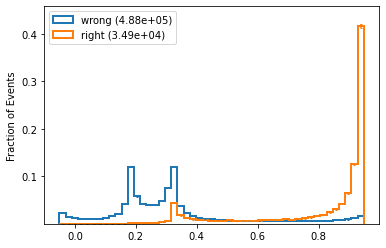

In [132]:
mask = training.nhiggs==3
pred = reg_model.predict(training.scores)/np.sum(coef)
hist_multi([pred[~mask],pred[mask]],labels=["wrong","right"],density=1)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

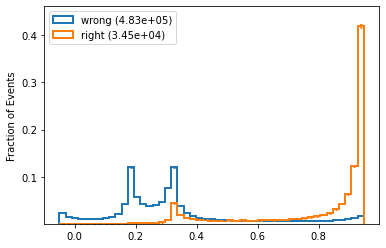

In [133]:
mask = testing.nhiggs==3
pred = reg_model.predict(testing.scores)/np.sum(coef)
hist_multi([pred[~mask],pred[mask]],labels=["wrong","right"],density=1)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

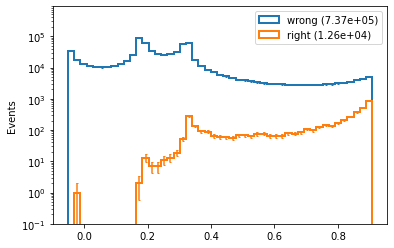

In [135]:
mask = validation.nhiggs==3
pred = reg_model.predict(validation.scores)/np.sum(coef)
hist_multi([pred[~mask],pred[mask]],labels=["wrong","right"],density=0,log=1)

0.6104182377168049


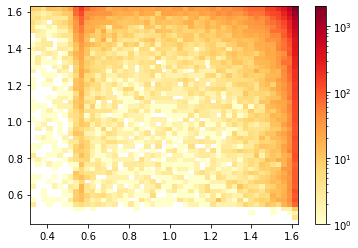

In [182]:
tru,fak = get_signal_bkgs(reg_model.predict(testing.scores),testing.nhiggs==3)
hist2d_simple(tru,fak)
print( np.sum(tru>fak)/len(tru) )

In [136]:
from sklearn.metrics import accuracy_score
def eval_model(model,dataset):

    trumask = dataset.nhiggs == 3

    accuracy = accuracy_score(dataset.nhiggs//3,nb_gauss_model.predict(dataset.scores))
    efficiency = accuracy_score(dataset.nhiggs[trumask]//3,model.predict(dataset.scores[trumask]))
    misstagrate = 1 - accuracy_score(dataset.nhiggs[~trumask]//3,model.predict(dataset.scores[~trumask]))
    return accuracy,efficiency,misstagrate

print_eval = lambda values,tag : print(f"{tag} => Accuracy: {values[0]:0.2f} - Efficiency: {values[1]:0.2f} - MissTag: {values[2]:0.2}")


In [194]:
from sklearn.naive_bayes import GaussianNB

nb_gauss_model = GaussianNB().fit(training.scores,training.nhiggs//3)

In [195]:
print_eval(eval_model(nb_gauss_model,training),  'Training  ')
print_eval(eval_model(nb_gauss_model,testing),   'Testing   ')
print_eval(eval_model(nb_gauss_model,validation),'Validation')

Training   => Accuracy: 0.85 - Efficiency: 0.89 - MissTag: 0.15
Testing    => Accuracy: 0.85 - Efficiency: 0.88 - MissTag: 0.15
Validation => Accuracy: 0.89 - Efficiency: 0.94 - MissTag: 0.12


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:ylabel='Events'>)

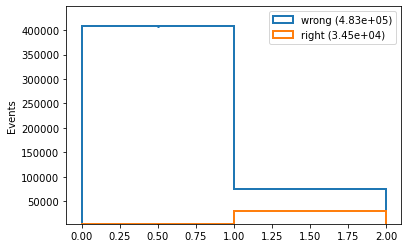

In [202]:
mask = testing.nhiggs==3
pred = nb_gauss_model.predict(testing.scores)
hist_multi([pred[~mask],pred[mask]],labels=["wrong","right"],bins=range(3))

In [201]:
score,truth = event_reshape(nb_gauss_model.predict(testing.scores),testing.nhiggs==3)

ak.sum(ak.sum(score,axis=-1)==1)

4729

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

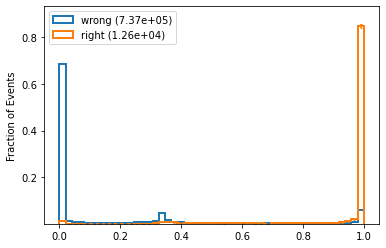

In [18]:
mask = validation.nhiggs==3
pred = nb_gauss_model.predict_proba(validation.scores)[:,1]
hist_multi([pred[~mask],pred[mask]],labels=["wrong","right"],density=1)

In [19]:
from sklearn.naive_bayes import MultinomialNB

nb_multi_model = MultinomialNB().fit(training.scores,training.nhiggs//3)

In [119]:
print_eval(eval_model(nb_multi_model,training),  'Training  ')
print_eval(eval_model(nb_multi_model,testing),   'Testing   ')
print_eval(eval_model(nb_multi_model,validation),'Validation')


Training   => Accuracy: 0.85 - Efficiency: 0.00 - MissTag: 0.0
Testing    => Accuracy: 0.85 - Efficiency: 0.00 - MissTag: 0.0
Validation => Accuracy: 0.89 - Efficiency: 0.00 - MissTag: 0.0


0.5990196647137305


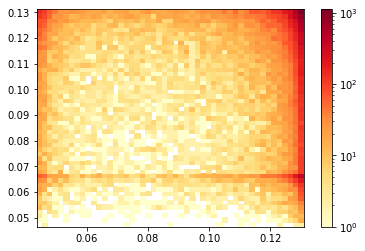

In [120]:
tru,fak = get_signal_bkgs(nb_multi_model.predict_proba(testing.scores)[:,1],testing.nhiggs==3)
hist2d_simple(tru,fak)
print( np.sum(tru>fak)/len(tru) )

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:ylabel='Fraction of Events'>)

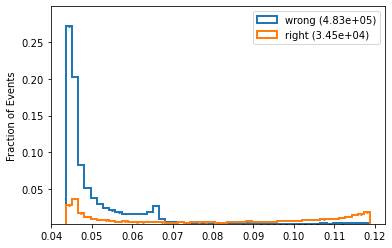

In [21]:
mask = testing.nhiggs==3
pred = nb_multi_model.predict_proba(testing.scores)[:,1]
hist_multi([pred[~mask],pred[mask]],labels=["wrong","right"],density=1)